# 2. Data Balance with Oversampling
---

In this notebook, we will look at the hashtags labels for each image, and fix the imbalance.

## Import Libraries (the following cells are copied from notebook 1)

In [2]:
import pandas as pd
import numpy as np
from scipy.linalg import null_space
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import shuffle

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import sys
sys.path.append("../src")

## Create the Target Matrix
Form ```tag_list.txt``` and ```data_list.txt``` in HARRISON dataset, we create a target matrix as a DataFrame.

In [10]:
DATA_LIST = "../HARRISON/data_list.txt"
TAG_LIST = "../HARRISON/tag_list.txt"

# Read files
filename = pd.read_csv(DATA_LIST, names=["filename"], header=None)
hashtag = pd.read_csv(TAG_LIST, names=["labels"], header=None)

# Convert filenames from "instagram_dataset/xxx/yyy.jpg" to "xxx_yyy.jpg"
filename["filename"] = filename["filename"].apply(lambda x: "_".join(x.split("/")[1:]))

# Concatenate filname and labels
target = pd.concat([filename, hashtag], axis=1)
target.head(5)

,filename,labels
0,sea_image_50.jpg,sea instapic instagram trip travel
1,sea_image_1284.jpg,sea
2,sea_image_1122.jpg,sea love
3,sea_image_1679.jpg,beach sea trip island japan
4,sea_image_1736.jpg,sun sand sea sky friend beach thailand trip ad...


In [11]:
# Use vectorizer to generate a one-hot encoding
vectorizer = CountVectorizer(binary=True)
X = vectorizer.fit_transform(target["labels"])
columns = vectorizer.get_feature_names()
X_df = pd.DataFrame(X.toarray(), columns=columns)

# Combine hashtag encodings with file names
target = pd.concat([target, X_df], axis=1)
target = shuffle(target, random_state=42)

num_images = target.shape[0]
num_hashtags = X_df.shape[1]

## Visualize the data imbalance

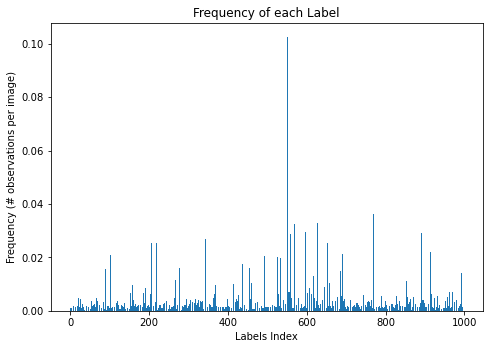

Variance in Frequency: 6.271672470561842e-05
5 Most Common Labels: ['love' 'friend' 'beach' 'family' 'yellow']


In [12]:
def display_probability_bar_graph(label_series):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    row_names = np.arange(0,label_series.shape[0])#label_prob_df.index
    ax.bar(row_names,label_series)
    ax.set_title('Frequency of each Label')
    ax.set_ylabel('Frequency (# observations per image)')
    ax.set_xlabel('Labels Index')
    plt.show()
    print("Variance in Frequency:",label_series.var())
    print("5 Most Common Labels:",label_series.nlargest(n=5).index.values)

def get_label_probabilities(df):
    return df.sum(axis=0) / df.shape[0]
    
display_probability_bar_graph(get_label_probabilities(X_df))

## Balance the data

In [26]:
#add some empirically tested columns of similar labels
balanced_X_df = X_df.copy()
zeros_col = np.zeros(balanced_X_df.shape[0])
added_cols = ['emotion','devotion','heartstrings','lovingness','amber','household','crew','den','oceanfront','shore','amigo','companion']
for col in added_cols:
    balanced_X_df[col] = zeros_col
print(X_df.shape)
print(balanced_X_df.shape)

(57383, 997)
(57383, 1009)


In [1]:
#use NLP to measure frequency
from nltk.corpus import wordnet as wn
from nltk.tag import pos_tag

#get part of speech
def get_pos(word):
    tag = pos_tag([word])[0][1]
    if tag.startswith("NN"):
        pos = 'n'
    elif tag.startswith('VB'):
        pos = 'v'
    else:
        pos = 'a'
    return pos

#return wn synset for a word
def word2synset(word):
    #find the synset for the word
    synsets = wn.synsets(word)
    #word AND no related synset found
    if( len(synsets) == 0 ):
        return None
    #find specified synset in synsets
    synset = None
    for s in synsets:
        if word.lower() == s.lemmas()[0].name().lower():
            synset = s
            break
    #none found choose the next best synset
    if synset is None:
        return synsets[0]
    else:
        return synset

    
#return set of synonyms for a word
def get_synonyms(word):
    synset = word2synset(word)
    if synset is None:
        return []
    synset_flattened = []
    for hn in synset.hypernyms() + synset.hyponyms() + synset.member_holonyms() + synset.root_hypernyms():
        synset_flattened += hn.lemma_names()
    synset_flattened += [str(lemma.name()) for lemma in synset.lemmas()]
    return synset_flattened

#get similarity
def get_similarity(word1,word2):
    synset1 = word2synset(word1)
    synset2 = word2synset(word2)
    if (synset1 is not None) and (synset2 is not None) :
        similarity = synset1.path_similarity(synset2)
        if (similarity is not None) :
            return similarity
    return 0

In [28]:
import os
from os import path

#some "colloquialisms" are not recognized, we need a conversion dictionary
filename = "."+os.sep+"colloq_dict.csv"
if path.exists(filename):
    colloq_word_df = pd.read_csv(filename,header=None,index_col=0).dropna()
    colloq_word_dict = colloq_word_df.to_dict(orient='index')
    #flatten
    for key in colloq_word_dict:
        colloq_word_dict[key] = colloq_word_dict[key][1]
else:
    print("ERROR:",filename,"not found!!!")

def colloq2word(colloq_word):
    if colloq_word not in colloq_word_dict:
        return colloq_word
    else:
        return colloq_word_dict[colloq_word]

print(colloq2word('completelyUnknownWord'))
print(colloq2word('besties'))

completelyUnknownWord
best_friend


In [29]:
#filename
filename = "."+os.sep+"similarity_matrix.csv"

#check if the similarity matrix can be read from a file
if path.exists(filename):
    similarity_matrix = pd.read_csv(filename)
#otherwise build the similarity matrix
else:
    labels = balanced_X_df.columns
    num_labels = len(labels)
    similarity_matrix = pd.DataFrame(data = np.zeros((num_labels,num_labels)), index = labels, columns = labels)

    #fill matrix
    for i in range(num_labels):
        label_i_common_word = colloq2word(labels[i])
        for j in range(i,num_labels):
            similarity = 0.0
            if i != j :
                label_j_common_word = colloq2word(labels[j])
                similarity = get_similarity(  label_i_common_word  ,  label_j_common_word  )
            similarity_matrix.iloc[i,j] = similarity_matrix.iloc[j,i] = similarity

    #save the csv to a file
    similarity_matrix.to_csv(filename,index_label=False)

#print the matrix
similarity_matrix.head(10)

,ab,accessory,actor,actress,adidas,adorable,adventure,aesthetic,afternoon,air,...,heartstrings,lovingness,amber,household,crew,den,oceanfront,shore,amigo,companion
ab,0.000000,0.066667,0.071429,0.066667,0.066667,0.0,0.071429,0.071429,0.166667,0.076923,...,0.076923,0.076923,0.071429,0.083333,0.083333,0.083333,0.083333,0.083333,0.076923,0.076923
accessory,0.066667,0.000000,0.090909,0.083333,0.200000,0.0,0.062500,0.062500,0.071429,0.090909,...,0.066667,0.066667,0.062500,0.071429,0.071429,0.071429,0.125000,0.125000,0.100000,0.100000
actor,0.071429,0.090909,0.000000,0.500000,0.090909,0.0,0.066667,0.066667,0.076923,0.100000,...,0.071429,0.071429,0.066667,0.076923,0.076923,0.076923,0.111111,0.111111,0.166667,0.166667
actress,0.066667,0.083333,0.500000,0.000000,0.083333,0.0,0.062500,0.062500,0.071429,0.090909,...,0.066667,0.066667,0.062500,0.071429,0.071429,0.071429,0.100000,0.100000,0.142857,0.142857
adidas,0.066667,0.200000,0.090909,0.083333,0.000000,0.0,0.062500,0.062500,0.071429,0.090909,...,0.066667,0.066667,0.062500,0.071429,0.071429,0.071429,0.125000,0.125000,0.100000,0.100000
adorable,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
adventure,0.071429,0.062500,0.066667,0.062500,0.062500,0.0,0.000000,0.076923,0.076923,0.071429,...,0.071429,0.071429,0.066667,0.076923,0.076923,0.076923,0.076923,0.076923,0.071429,0.071429
aesthetic,0.071429,0.062500,0.066667,0.062500,0.062500,0.0,0.076923,0.000000,0.076923,0.071429,...,0.071429,0.071429,0.066667,0.076923,0.076923,0.076923,0.076923,0.076923,0.071429,0.071429
afternoon,0.166667,0.071429,0.076923,0.071429,0.071429,0.0,0.076923,0.076923,0.000000,0.083333,...,0.083333,0.083333,0.076923,0.090909,0.090909,0.090909,0.090909,0.090909,0.083333,0.083333
air,0.076923,0.090909,0.100000,0.090909,0.090909,0.0,0.071429,0.071429,0.083333,0.000000,...,0.076923,0.076923,0.071429,0.083333,0.083333,0.083333,0.125000,0.125000,0.111111,0.111111


In [6]:
word = 'snowy'
print(word2synset(word))
print(get_synonyms(word))

Synset('white.s.04')
['white', 'snowy', 'white', 'snowy']


In [32]:
#set the similarity threshold
THRESHOLD = 0.3
similarity_matrix = (similarity_matrix >= THRESHOLD).astype('int32')

In [33]:
import timeit

#utility function

#df: dataframe of 1s and 0s
#remove_series: pd.Series
#returns df with x random 1s removed from column i, where x is the ith element of remove_series. If prevent_zero_rows is true, a 1 will not be removed if it is the last 1 in its row
def remove_ones(df,remove_series,prevent_zero_rows=False,DEBUG=False) :
    for i in range(0,df.shape[1]):
        num_ones_to_remove = remove_series[i]
        if(num_ones_to_remove == 0):
            continue
        if DEBUG:
            start = timeit.default_timer()
        col = df.iloc[:,i]
        if prevent_zero_rows:
            col *= (df.sum(axis=1) - 1) # 0 out rows with only 1 label left
        ones_indicies = col[col >= 1].index.to_numpy()
        num_ones_to_remove = min(ones_indicies.shape[0],num_ones_to_remove)
        ones_indicies_to_remove = np.random.choice(ones_indicies,num_ones_to_remove,replace=False)
        df.iloc[ones_indicies_to_remove,i] = 0
        if DEBUG:
            stop = timeit.default_timer()
            print("Total Time: ",stop-start," Ones to Remove: ",num_ones_to_remove)
    return df

df = pd.DataFrame([[1,1,1,1],[1,1,1,1],[1,1,1,1]])
remove_series = pd.Series([0,1,2,3])
print(remove_ones(df,remove_series))

   0  1  2  3
0  1  1  0  0
1  1  1  1  0
2  1  0  0  0


In [34]:
#setup structures for loop
frequency_dict = pd.DataFrame(balanced_X_df.sum(axis=0))
av_freq = frequency_dict.mean(axis=0)[0]

#performs numpy (w broadcasting) multiplication on df1 and df2 returning a new dataframe with index,columns of df3
multiply_positional_index = lambda df1,df2,df3 : pd.DataFrame(data=(df1.to_numpy() * df2.to_numpy()), index=df3.index, columns=df3.columns)

#use similarity to perform substitutions that lower data imbalance
ITERATIONS = 1
for i in range(ITERATIONS):
    #print current variance
    print("Iteration:",i,"| Var:",get_label_probabilities(balanced_X_df).var())

    #create a matrix of allowed substitutions (1 if Label I -> Label J allowed, else 0)
    underrepresented_dict = (1.0 * (frequency_dict < av_freq)).transpose()
    substitutions_df = multiply_positional_index(similarity_matrix, underrepresented_dict, similarity_matrix)

    #perform substitutions:
    update_df = balanced_X_df.dot(substitutions_df).astype('int32')

    #remove some substituted tags from update_df that are now over-represented
    counts_obtained = update_df.sum(axis=0)
    counts_needed = (((av_freq - frequency_dict) > 0) * (av_freq - frequency_dict)).iloc[:,0]
    remove_series = (((counts_obtained - counts_needed) > 0) * (counts_obtained - counts_needed)).astype('int32')
    update_df = remove_ones(update_df,remove_series,prevent_zero_rows=False,DEBUG=False).astype('int32')

    #remove some overrepresented tags that were substituted
    counts_to_remove = (((frequency_dict - av_freq) > 0) * (frequency_dict - av_freq)).iloc[:,0]
    #dont reduce counts of labels with no substitutions
    labels_with_substitutions = (substitutions_df.sum(axis=1) >= 1)
    remove_series = (counts_to_remove * labels_with_substitutions).astype('int32')
    balanced_X_df = remove_ones(balanced_X_df,remove_series,prevent_zero_rows=True,DEBUG=False).astype('int32')

    #update dataframe and calculate new frequencies
    balanced_X_df = pd.DataFrame(data=np.logical_or(balanced_X_df , update_df) ,index=balanced_X_df.index,columns=balanced_X_df.columns).astype('int32')
    frequency_dict = pd.DataFrame(balanced_X_df.sum(axis=0))
    av_freq = frequency_dict.mean(axis=0)[0]

print("Completed",ITERATIONS,"iterations! | Var:",get_label_probabilities(balanced_X_df).var())

Iteration: 0 | Var: 6.221446625135493e-05
Completed 1 iterations! | Var: 1.2866975200477812e-05


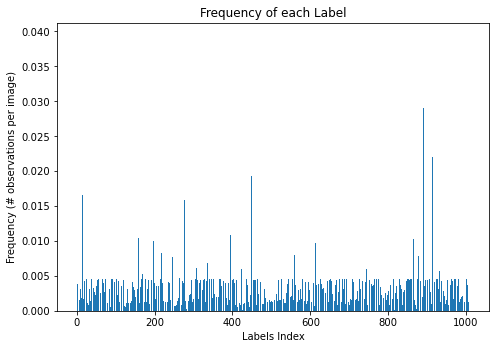

Variance in Frequency: 1.2866975200477812e-05
5 Most Common Labels: ['nike' 'bored' 'school' 'black' 'instagood']


In [35]:
display_probability_bar_graph(get_label_probabilities(balanced_X_df))

## Save the dataframes as a files

In [36]:
import os
tag_list_pathname = os.path.join("..","HARRISON","tag_list_similarity_balanced.txt")
data_list_pathname = os.path.join("..","HARRISON","data_list_similarity_balanced.txt")

tag_list_oversampled_df = balanced_X_df.dot((balanced_X_df.columns.to_numpy() + " "))
data_list_oversampled_df = target.loc[balanced_X_df.index,'filename']

tag_list_oversampled_df.to_csv(tag_list_pathname,header=False,index=False)
data_list_oversampled_df.to_csv(data_list_pathname,header=False,index=False)

In [19]:
a=pd.DataFrame({0:[1,2],1:[2,4],2:[4,8]})
b=pd.DataFrame({0:[1,2],1:[2,4],3:[4,8]})

a_intersection_b = set(a.columns) - (set(a.columns) - set(b.columns))
b_not_in_a = set(b.columns) - set(a.columns)

a = a.loc[:,a_intersection_b]
a.loc[:,b_not_in_a] = [0,0]
print(a)

   0  1  3
0  1  2  0
1  2  4  0
